In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random

In [0]:
np.random.seed(0)
tf.set_random_seed(1234)

In [0]:
def inference(x, n_batch, maxlen, n_hidden = None , n_out = None):
  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)
  
  def bias_variable(shape):
    initial = tf.zeros(shape, dtype = tf.float32)
    return tf.Variable(initial)
  #覗き穴結合はないが計算時間が短縮できるBasicLSTMCellを採用
  cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias = 1.0)
  initial_state = cell.zero_state(n_batch, tf.float32)
  
  state = initial_state
  outputs = []
  with tf.variable_scope('LSTM'):
    for t in range(maxlen):
      if t > 0:
        tf.get_variable_scope().reuse_variables()
      (cell_output, state) = cell(x[:,t,:], state)
      outputs.append(cell_output)
      
  output = outputs[-1]
  
  V = weight_variable([n_hidden, n_out])
  c = bias_variable([n_out])
  y = tf.matmul(output, V) + c
  
  return y

In [0]:
def loss(y,t):
  mse = tf.reduce_mean(tf.square(y - t))
  return mse

In [0]:
def training(loss):
  optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999)
  train_step = optimizer.minimize(loss)
  return train_step

In [0]:
if __name__ == '__main__':
  def mask(T = 200):
    mask = np.zeros(T)
    indices = np.random.permutation(np.arange(T))[:2]
    mask[indices] = 1
    return mask
  
  def toy_problem(N = 10, T = 200):
    signals = np.random.uniform(low = 0.0, high = 1.0, size = (N,T))
    masks = np.zeros((N,T))
    for i in range(N):
      masks[i] = mask(T)
    
    data = np.zeros((N, T, 2))
    data[:,:,0] = signals[:]
    data[:,:,1] = masks[:]
    target = (signals * masks).sum(axis = 1).reshape(N, 1)
    
    return (data, target)

In [0]:
  #データ生成
  N = 10000
  T = 200
  maxlen = T
  
  X , Y = toy_problem(N = N,T = T)
  
  N_train = int(N*0.9)
  N_validation = N - N_train
  
  X_train, X_validation ,Y_train,Y_validation = train_test_split(X,Y, test_size = N_validation)

In [8]:
  #モデル設定
  n_in = len(X[0][0])
  n_hidden = 100
  n_out = len(Y[0])
  
  x = tf.placeholder(tf.float32, shape = [None, maxlen, n_in])
  t = tf.placeholder(tf.float32, shape = [None, n_out])
  n_batch = tf.placeholder(tf.int32, shape=[])
  
  y = inference(x, n_batch, maxlen = maxlen,n_hidden = n_hidden, n_out = n_out)
  loss = loss(y,t)
  train_step = training(loss)
  
  history = {
      'val_loss': []
  }

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
  #モデル学習
  epochs = 300
  batch_size = 500
  
  init = tf.global_variables_initializer()
  sess = tf.Session()
  sess.run(init)
  
  n_batches = N_train // batch_size
  X_ = X_train
  Y_ = Y_train
  
  for epoch in range(epochs):
    seed_num = random.randrange(1000)
    print('seed_num : ',seed_num)
    np.random.seed(seed_num)
    np.random.shuffle(X_)
    np.random.seed(seed_num)
    np.random.shuffle(Y_)
    
    for i in range(n_batches):
      start = i * batch_size
      end = start + batch_size
      
      sess.run(train_step, feed_dict = {
          x: X_[start:end],
          t: Y_[start:end],
          n_batch: batch_size
      })
      
    #検証データによる評価
    val_loss = loss.eval(session = sess, feed_dict = {
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    
    history['val_loss'].append(val_loss)
    print('epoch: ',epoch, 'validation loss: ',val_loss)

seed_num :  852
epoch:  0 validation loss:  0.20695837
seed_num :  589
epoch:  1 validation loss:  0.18033777
seed_num :  619
epoch:  2 validation loss:  0.1731975
seed_num :  865
epoch:  3 validation loss:  0.17234403
seed_num :  723
epoch:  4 validation loss:  0.17222045
seed_num :  519
epoch:  5 validation loss:  0.17209454
seed_num :  524
epoch:  6 validation loss:  0.17223297
seed_num :  998
epoch:  7 validation loss:  0.17205957
seed_num :  23
epoch:  8 validation loss:  0.17222854
seed_num :  22
epoch:  9 validation loss:  0.17243513
seed_num :  432
epoch:  10 validation loss:  0.17243396
seed_num :  334
epoch:  11 validation loss:  0.1720588
seed_num :  665
epoch:  12 validation loss:  0.17219336
seed_num :  854
epoch:  13 validation loss:  0.17205454
seed_num :  85
epoch:  14 validation loss:  0.17208713
seed_num :  525
epoch:  15 validation loss:  0.17205194
seed_num :  324
epoch:  16 validation loss:  0.1720521
seed_num :  847
epoch:  17 validation loss:  0.17213786
seed_num

<function matplotlib.pyplot.show>

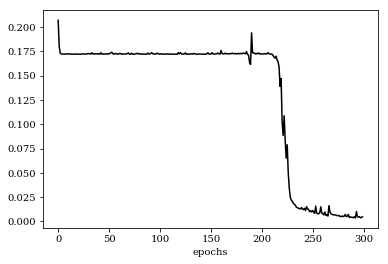

In [10]:
  #学習を可視化
  loss = history['val_loss']
  
  plt.rc('font', family = 'serif')
  fig = plt.figure()
  plt.plot(range(len(loss)), loss, label = 'loss',color = 'black')
  plt.xlabel('epochs')
  plt.show